# EDA on 911 calls

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('911.csv')

## Columns

In [3]:
df.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'addr', 'e'], dtype='object')

## Trying to understand columns meaning

**lat**: *latitude of the call* (float)

**lng**: *longitude of the call* (float)

**desc**: time and source of the call. Formatted as follows: 'road name; city name; yyyy-mm-dd @ hours:minutes:seconds;' (str)

**zip**: zip code (Float)

**title**: reason of the call (str)

**timeStamp**: date and time of the call 'yyyy-mm-dd hours:minutes:seconds' (str). I see there's always a gap between the time in **desc** and the time here. Maybe the time here represents the end of the call, while the other one the start of the call

**twp**: City (str)

**addr**: road name (str)

**e**: no idea. Each row has 1 as value (int). May be this is a sliced dataframe of the original one

## Rows missing values

from the following visual representations we can see that over the 99492 rows, we miss:

- lat : 0%

- lng : 0%

- desc : 0%

- zip : 13%

- title : 0%

- timeStamp : 0%

- twp : < 1%

- addr : < 1%

- e : 0%

<AxesSubplot:>

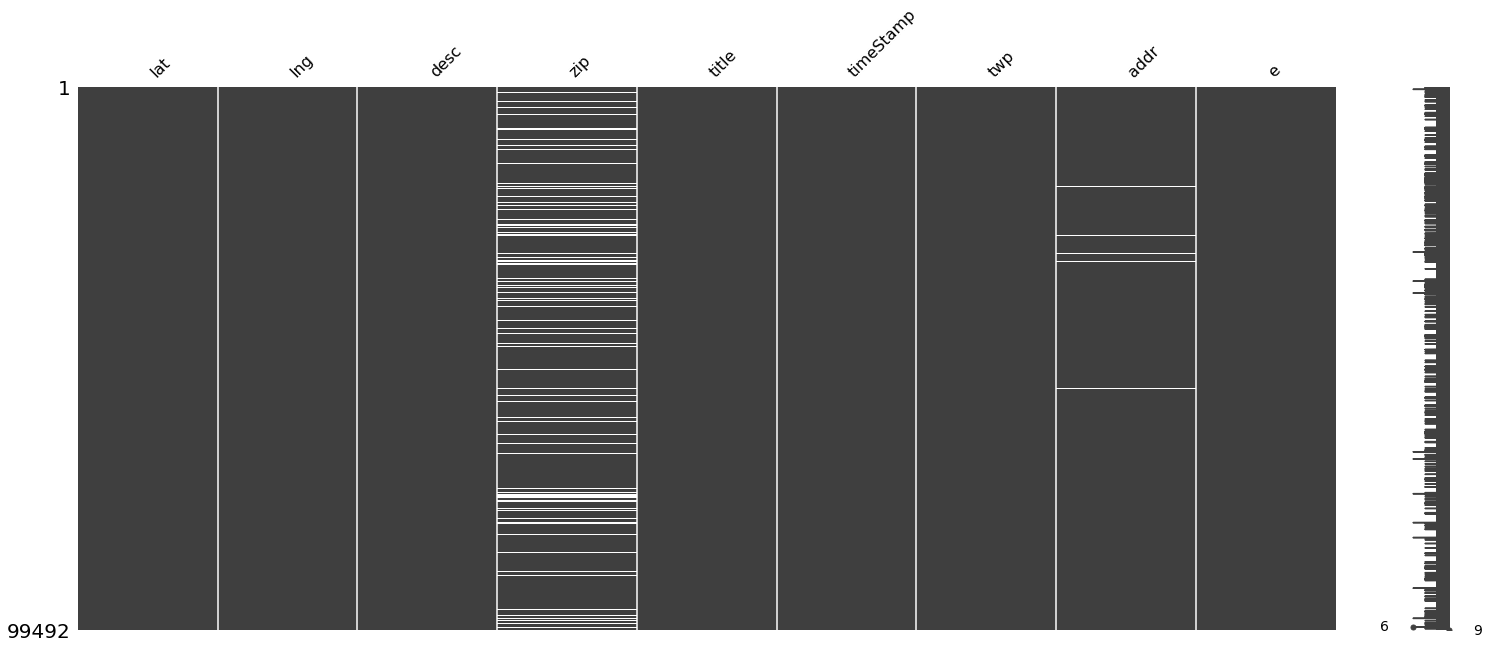

In [4]:
msno.matrix(df)

<AxesSubplot:>

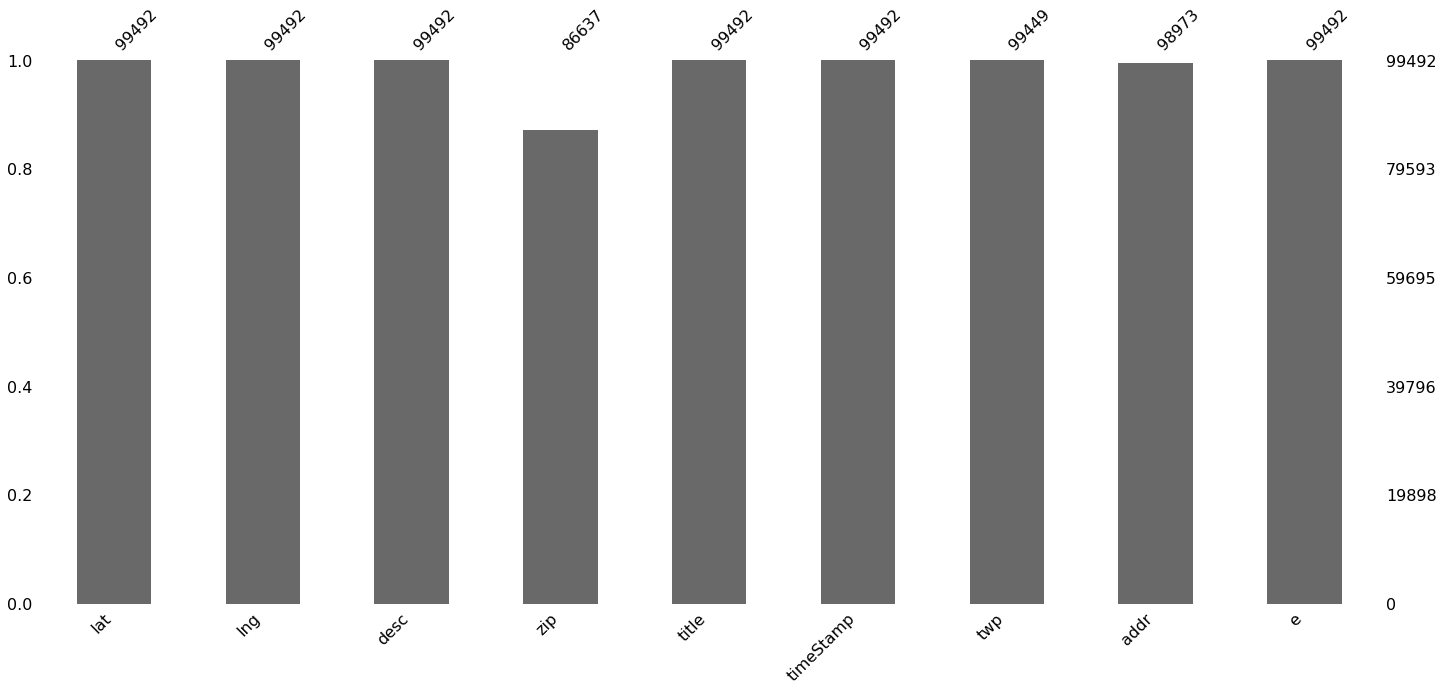

In [5]:
msno.bar(df)

## Columns drop

Because all the informations contained in **desc** are better formatted in **addr**, **twp** and **timeStamp** we could safetly discard it.

Because I cannot find the meaning of **e** and it has the same value for each row anyway, we could safetly discard it too.

In [6]:
new_df = df.drop(['desc', 'e'], axis=1)
new_df.head()

,lat,lng,zip,title,timeStamp,twp,addr
0,40.297876,-75.581294,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END
1,40.258061,-75.264680,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN
2,40.121182,-75.351975,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE
3,40.116153,-75.343513,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST
4,40.251492,-75.603350,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END


## TITLE

We see a general category (e.g. EMS, Traffic, ...) followed by a more specific description

Now we know that there are 3 main categories:

- EMS (Emergency Medical Services)
- Fire
- Traffic

In [7]:
new_df.groupby([new_df.title.transform(lambda x : x.split(':')[0])])['title'].count()

title
EMS        48877
Fire       14920
Traffic    35695
Name: title, dtype: int64

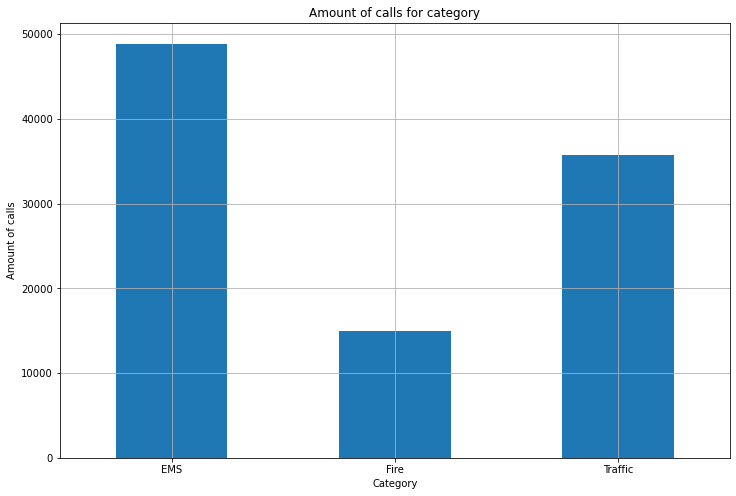

In [8]:
new_df.groupby([new_df.title.transform(lambda x : x.split(':')[0])])['title'].count().plot.bar(figsize = (12, 8))
plt.title('Amount of calls for category')
plt.xlabel('Category')
plt.ylabel('Amount of calls')
plt.xticks(rotation = 0)
plt.grid()
plt.show()

In [9]:
EMS = new_df[new_df.title.str.startswith('EMS')]['title']

def category_plot(category):
    diz = {}
    
    for specification in category:
        title, spec = specification.strip().split(':')
        if spec not in diz:
            diz[spec] = 1
        else:
            diz[spec] += 1
    
    lst = []
    
    for key in diz:
        lst.append((key, diz[key]))
    lst.sort(key = lambda x : x[1], reverse = True)
    
    x = [i[0].strip('-').strip() for i in lst][:10]
    y = [i[1] for i in lst][:10]
    
    plt.figure(figsize = (12, 8))
    plt.barh(x, y)
    plt.title(f'TOP {len(x)} calls: {title}')
    plt.xlabel('N° of calls')
    plt.grid()
    plt.show()

### EMS

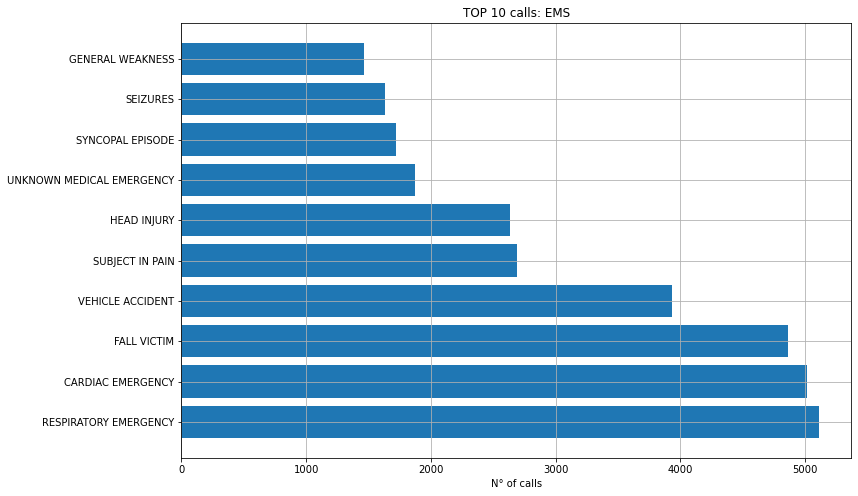

In [10]:
EMS = new_df[new_df.title.str.startswith('EMS')]['title']

category_plot(EMS)

## Fire

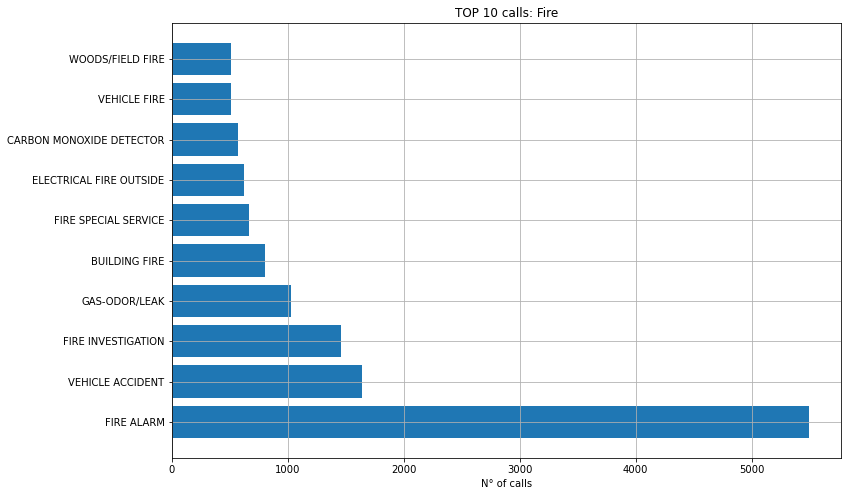

In [11]:
Fire = new_df[new_df.title.str.startswith('Fire')]['title']

category_plot(Fire)

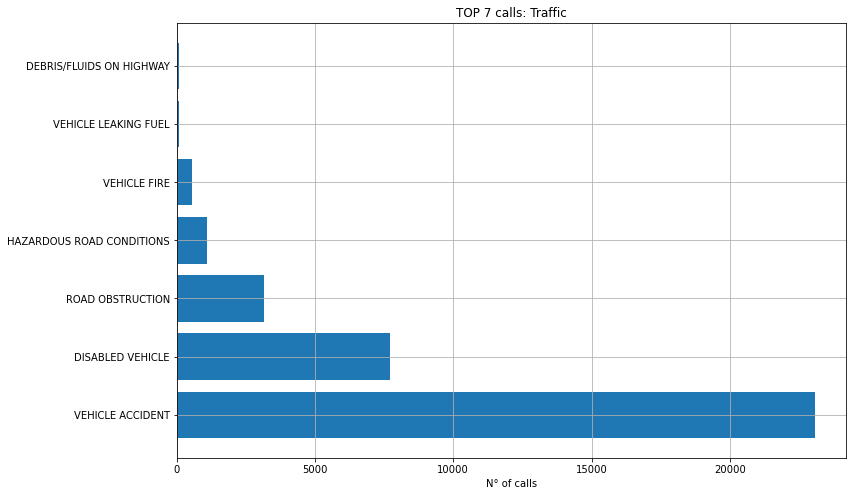

In [12]:
Traffic = new_df[new_df.title.str.startswith('Traffic')]['title']

category_plot(Traffic)

Let's see at the Rank regardless the specification

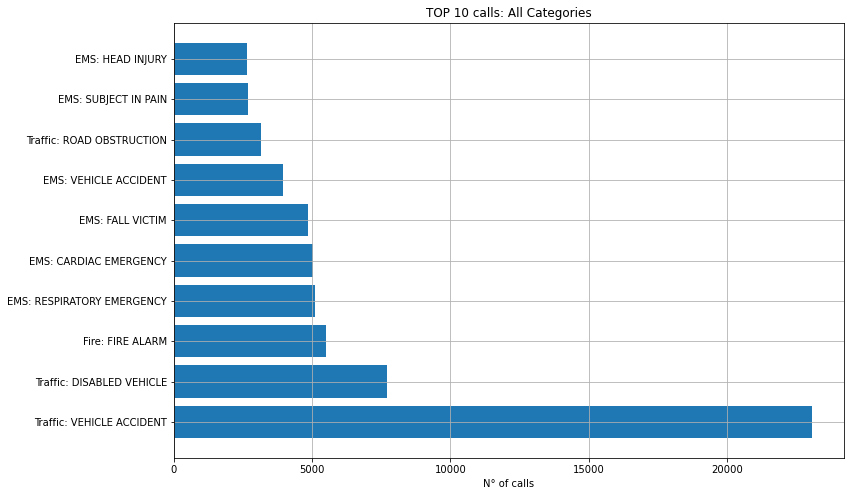

In [13]:
all_titles = new_df[new_df.title.str.contains(':')]['title']

diz = {}

for specification in all_titles:
    spec = specification.strip()
    if spec not in diz:
        diz[spec] = 1
    else:
        diz[spec] += 1
        
lst = []

for key in diz:
    lst.append((key, diz[key]))
lst.sort(key = lambda x : x[1], reverse = True)


x = [i[0].strip('-').strip() for i in lst][:10]
y = [i[1] for i in lst][:10]

plt.figure(figsize = (12, 8))
plt.barh(x, y)
plt.title(f'TOP 10 calls: All Categories')
plt.xlabel('N° of calls')
plt.grid()
plt.show()

Here we can see Vehicle accident overlaps Traffic and EMS categories (also Fire). But we don't know whether and which of them are linked to the same call.
Taking a look to the time call, it seems like some of them could be associated to the same event. But actually we cannot be sure about this

In [14]:
diz = {}

for i in lst:
    x, y = i[0].strip('-').strip().split(':')[0], i[1]
    if x not in diz:
        diz[x] = y
    else:
        diz[x] += y

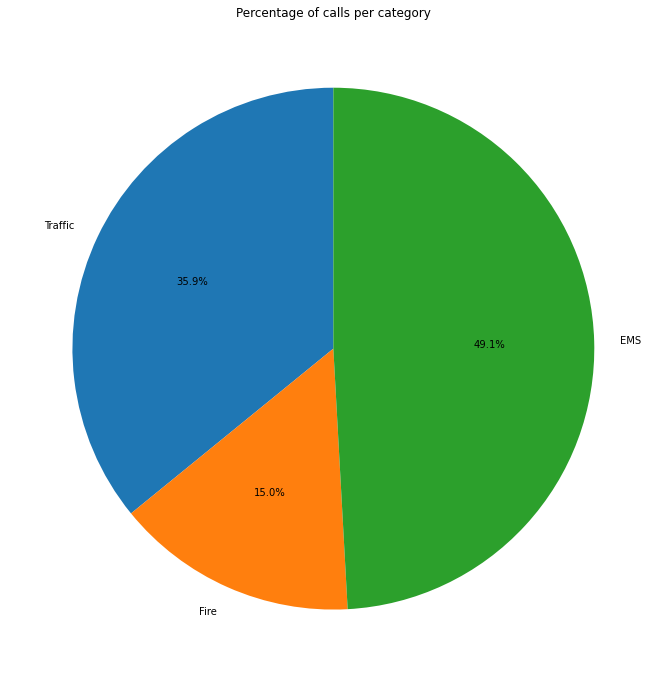

In [15]:
x = list(diz.keys())
y = list(diz.values())

plt.figure(figsize = (12, 12))
plt.pie(y, labels = x, autopct='%1.1f%%', startangle = 90)
plt.title('Percentage of calls per category')
plt.show()

## Rank calls by most frequent

EMS : 49.1%

- Respiratory Emergency
- Cardiac Emergency
- Vehicle Accident
- Subject in Pain

Traffic : 35.9%

- Vehicle Accident
- Disabled Vehicle

Fire : 15.0%

- Fire Alarm 
- Vehicle Accident

The majority of the calls are because of an EMS.
Looking at the specification, most of the calls are Vehicle related (accident, disabled vehicle...)

Going into details for each one:
- EMS: mostly because of respiratory or cardiac emergencies.
- Traffic: vehicle accident
- Fire: fire alarm

## Time analysis

Seems like over months (for the year taken into account) the situation has been stable, except for an upward spike between January and February and a downward spike at the start of May

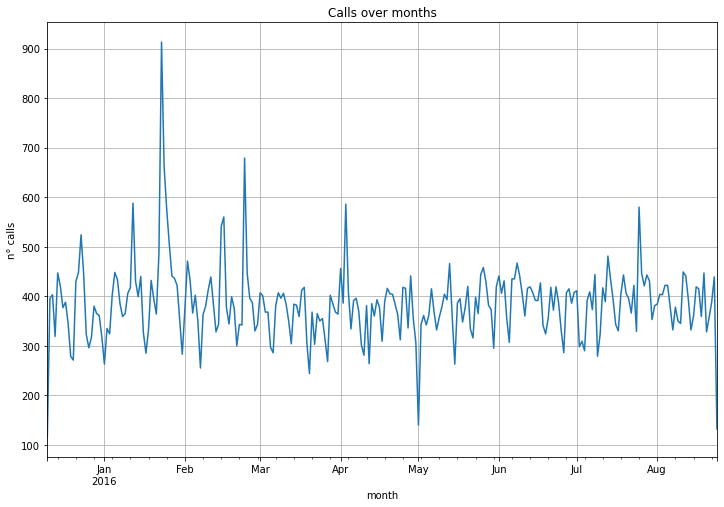

In [16]:
new_df['date'] = pd.to_datetime(new_df['timeStamp'].transform(lambda x : x.split()[0]))

new_df.groupby(['date'])['date'].count().plot.line(figsize = (12, 8))
plt.xlabel('month')
plt.ylabel('n° calls')
plt.title('Calls over months')
plt.grid()
plt.show()

Over the day we can notice:

- Upward trend: 05:30 - 17:00
- Downward trend: 17:00 to 5:30

Most of the calls are between ~ 8.10 and ~ 22.30 (more than 100)

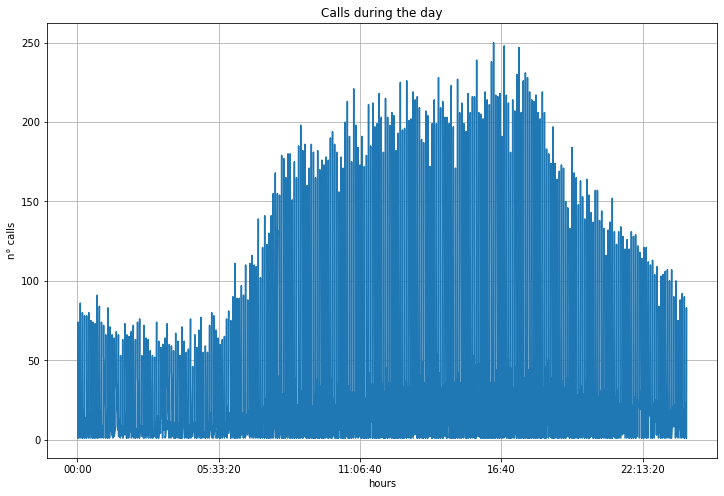

In [17]:
new_df['time'] = pd.to_datetime(new_df['timeStamp'].transform(lambda x : x.split()[1].strip())).dt.time

new_df.groupby(['time'])['time'].count().plot(figsize = (12, 8))
plt.xlabel('hours')
plt.ylabel('n° calls')
plt.title('Calls during the day')
plt.grid()
plt.show()

## Map Visualization

Looking at all the calls, seems like Norristown is an hot source with respect to the other areas

In [10]:
# map1 = folium.Map(location = [40.22282651400465, -75.39868795735254],
#                        zoom_start = 10)

# heat_df = new_df[['lat', 'lng']]

# heat_data = [[row["lat"], row["lng"]] for index, row in heat_df.iterrows()]

# HeatMap(heat_data, radius = 12).add_to(map1)

In [9]:
%%HTML
<iframe width="100%" height="500px" frameBorder="0" allowfullscreen src="map1.html"></iframe>

## EMS

In [ ]:
# ems = new_df[new_df['title'].transform(lambda x : x.split(':')[0] == 'EMS')]
                                                                  
# marker = folium.Map(location = [40.22282651400465, -75.39868795735254], zoom_start=10)

# mc = MarkerCluster()
# for idx, row in ems.iterrows():
#     mc.add_child(Marker([row['lat'], row['lng']]))
# marker.add_child(mc)

In [ ]:
%%HTML
<iframe width="100%" height="500px" frameBorder="0" allowfullscreen src="map2.html"></iframe>

## Fire

In [ ]:
# fire = new_df[new_df['title'].transform(lambda x : x.split(':')[0] == 'Fire')]
                                                                  
# marker = folium.Map(location = [40.22282651400465, -75.39868795735254], zoom_start=10)

# mc = MarkerCluster()
# for idx, row in fire.iterrows():
#     mc.add_child(Marker([row['lat'], row['lng']]))
# marker.add_child(mc)

In [ ]:
%%HTML
<iframe width="100%" height="500px" frameBorder="0" allowfullscreen src="map3.html"></iframe>

## Traffic

In [ ]:
# traffic = new_df[new_df['title'].transform(lambda x : x.split(':')[0] == 'Traffic')]
                                                                  
# marker = folium.Map(location = [40.22282651400465, -75.39868795735254], zoom_start=10)

# mc = MarkerCluster()
# for idx, row in traffic.iterrows():
#     mc.add_child(Marker([row['lat'], row['lng']]))
# marker.add_child(mc)

In [ ]:
%%HTML
<iframe width="100%" height="500px" frameBorder="0" allowfullscreen src="map4.html"></iframe>